In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
import requests
import os

In [2]:
import sys
csv.field_size_limit(sys.maxsize)

131072

In [3]:
# name of data file
birth_weight_file = 'birthweight.dat'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]


# Extract y-target (birth weight)
y_vals = np.array([x[8] for x in birth_data])

# Filter for features of interest
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI']
x_vals = np.array([[x[ix] for ix, feature in enumerate(birth_header) if feature in cols_of_interest] for x in birth_data])

In [4]:
# set batch size for training
batch_size = 150

# make results reproducible
seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
# Record training column max and min for scaling of non-training data
train_max = np.max(x_vals_train, axis=0)
train_min = np.min(x_vals_train, axis=0)

# Normalize by column (min-max norm to be between 0 and 1)
def normalize_cols(mat, max_vals, min_vals):
    return (mat - min_vals) / (max_vals - min_vals)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train, train_max, train_min))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, train_max, train_min))

In [6]:
# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random.normal(shape, stddev=st_dev))
    return weight

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random.normal(shape, stddev=st_dev))
    return bias

In [7]:
x_data = tf.keras.Input(dtype=tf.float32, shape=(7,))

In [8]:
# Create fully connected layer:

def fully_connected(input_layer, weights, biases):
    return tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, weights), biases)))(input_layer)

25 - 10 - 3

In [9]:
#--------Create the first layer (25 hidden nodes)--------
weight_1 = init_weight(shape=[7, 25], st_dev=5.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

#--------Create the second layer (10 hidden nodes)--------
weight_2 = init_weight(shape=[25, 10], st_dev=5.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)

#--------Create the third layer (3 hidden nodes)--------
weight_3 = init_weight(shape=[10, 3], st_dev=5.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)

#--------Create our output layer (1 output value)--------
weight_4 = init_weight(shape=[3, 1], st_dev=5.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

model = tf.keras.Model(inputs=x_data, outputs=final_output, name='multiple_layers_neural_network')

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(7, 25) dtype=float32>
  <tf.Variable 'Variable:0' shape=(25,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(25, 10) dtype=float32>
  <tf.Variable 'Variable:0' shape=(10,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(10, 3) dtype

In [10]:
# Declare Adam Optimizer
optimizer = tf.keras.optimizers.Adam(0.025)

# Training Loop
loss_vec = []
test_loss = []
for i in range(200):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    
    # Open a GradientTape
    with tf.GradientTape(persistent=True) as tape:
        
        # Forward pass.
        output = model(rand_x)
        
        # Apply loss function (MSE)
        loss = tf.reduce_mean(tf.abs(rand_y - output))
        loss_vec.append(loss)
        
    # Get gradients of loss with reference to the weights and bias variables to adjust
    gradients_w1 = tape.gradient(loss, weight_1)
    gradients_b1 = tape.gradient(loss, bias_1)
    gradients_w2 = tape.gradient(loss, weight_2)
    gradients_b2 = tape.gradient(loss, bias_2)
    gradients_w3 = tape.gradient(loss, weight_3)
    gradients_b3 = tape.gradient(loss, bias_3)
    gradients_w4 = tape.gradient(loss, weight_4)
    gradients_b4 = tape.gradient(loss, bias_4)
    
    # Update the weights and bias variables of the model.
    optimizer.apply_gradients(zip([gradients_w1, gradients_b1, gradients_w2, gradients_b2,
                                   gradients_w3, gradients_b3, gradients_w4, gradients_b4],
                                  [weight_1, bias_1, weight_2, bias_2, weight_3, bias_3, weight_4, bias_4]))
    
    # Forward pass.
    output_test = model(x_vals_test)
    # Apply loss function (MSE) on test
    temp_loss = tf.reduce_mean(tf.abs(np.transpose([y_vals_test]) - output_test))
    test_loss.append(temp_loss)
    
    if (i+1) % 25 ==0:
        print(f'Generation: {i+1}. Loss = {loss.numpy()}')

Generation: 25. Loss = 1921.7935791015625
Generation: 50. Loss = 1453.40234375
Generation: 75. Loss = 987.572998046875
Generation: 100. Loss = 709.82177734375
Generation: 125. Loss = 508.6255187988281
Generation: 150. Loss = 541.3716430664062
Generation: 175. Loss = 539.6121826171875
Generation: 200. Loss = 441.6407165527344


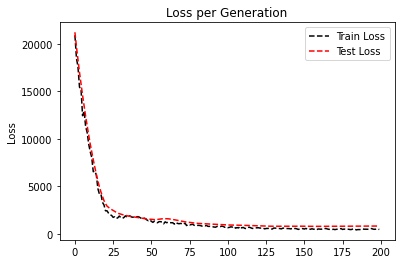

In [11]:
plt.plot(loss_vec, 'k--', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss per Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
# Model Accuracy
actuals = np.array([x[0] for x in birth_data])
test_actuals = actuals[test_indices]
train_actuals = actuals[train_indices]
test_preds = model(x_vals_test)
train_preds = model(x_vals_train)
test_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in test_preds])
train_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in train_preds])

# Print out accuracies
test_acc = np.mean([x == y for x, y in zip(test_preds, test_actuals)])
train_acc = np.mean([x == y for x, y in zip(train_preds, train_actuals)])
print('On predicting the category of low birthweight from regression output (<2500g):')
print(f'Test Accuracy: {test_acc}')
print(f'Train Accuracy: {train_acc}')

On predicting the category of low birthweight from regression output (<2500g):
Test Accuracy: 0.7631578947368421
Train Accuracy: 0.7880794701986755
